Found 56 images belonging to 5 classes.
Found 11 images belonging to 5 classes.
Clases detectadas: {'Allergies': 0, 'Autoimmune': 1, 'Healthy': 2, 'Infections': 3, 'Parasites': 4}
Tamaño del conjunto de entrenamiento: 56
Tamaño del conjunto de validación: 11


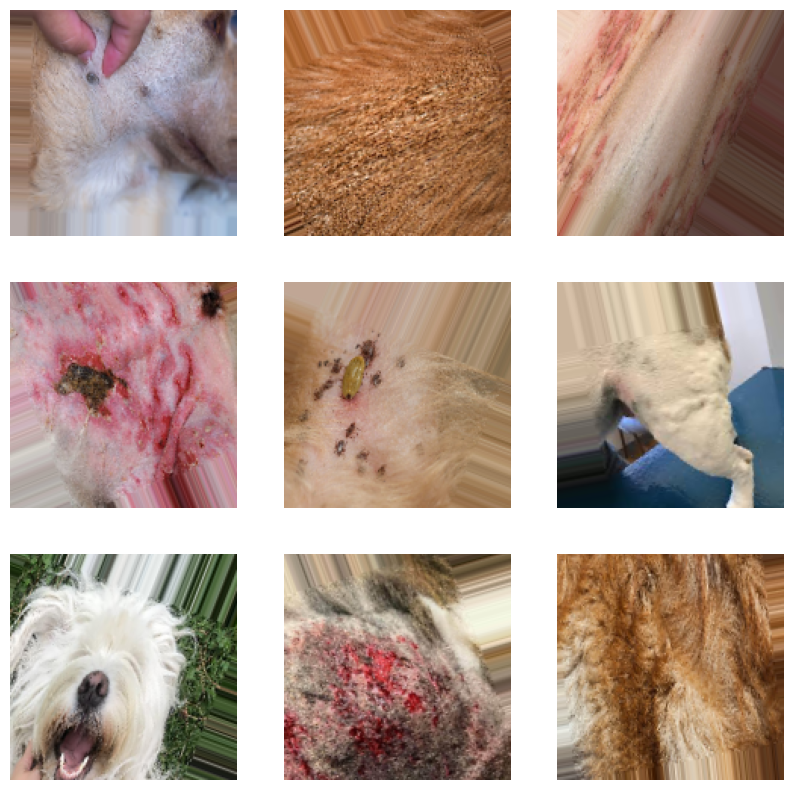

In [3]:
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorio base donde están las imágenes
base_dir = Path("Dogs2")

# Configuración de parámetros
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 16

# Data Augmentation para prevenir overfitting
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,          # Normalización
    rotation_range=30,          # Rotación aleatoria de hasta 30 grados
    width_shift_range=0.2,      # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,     # Desplazamiento vertical aleatorio
    zoom_range=0.2,             # Zoom aleatorio
    horizontal_flip=True,       # Flip horizontal
    fill_mode='nearest',        # Rellenar espacios tras transformaciones
    validation_split=0.2        # Dividir en 80% entrenamiento, 20% validación
)

# Generadores para datos de entrenamiento y validación
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Subset de entrenamiento
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # Subset de validación
)

# Visualizar las clases y número de imágenes por clase
print("Clases detectadas:", train_generator.class_indices)
print("Tamaño del conjunto de entrenamiento:", train_generator.samples)
print("Tamaño del conjunto de validación:", validation_generator.samples)

# Mostrar algunas imágenes generadas (opcional)
import matplotlib.pyplot as plt

# Tomar un batch de imágenes
batch_images, batch_labels = next(train_generator)

# Visualizar algunas imágenes
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(batch_images[i])
    plt.axis('off')
plt.show()


In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Configuraciones generales
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 16
EPOCHS = 20
N_SPLITS = 5  # Número de folds para cross-validation

# Cargar datos y etiquetas de manera estructurada
datagen = ImageDataGenerator(rescale=1.0 / 255)  # Solo normalización
data_generator = datagen.flow_from_directory(
    "Dogs2",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Mantener el orden para dividir los datos
)

# Extraer imágenes y etiquetas
images, labels = [], []
for _ in range(len(data_generator)):
    img_batch, label_batch = next(data_generator)  # Usar `next()`
    images.extend(img_batch)
    labels.extend(label_batch)

images = np.array(images)
labels = np.array(labels)

# Configuración del cross-validation
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold = 1

# Para guardar resultados
accuracies = []

for train_index, test_index in kf.split(images, np.argmax(labels, axis=1)):
    print(f"Training Fold {fold}...")
    
    # Dividir datos en entrenamiento y validación
    x_train, x_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Modelo CNN
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),  # Dropout para prevenir overfitting
        layers.Dense(128, activation="relu"),
        layers.Dense(labels.shape[1], activation="softmax")  # Salidas igual al número de clases
    ])

    # Compilar modelo
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # Early Stopping para evitar overfitting
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # Entrenar modelo
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluar en datos de validación
    eval_result = model.evaluate(x_test, y_test, verbose=0)
    accuracies.append(eval_result[1])  # Guardar accuracy
    print(f"Fold {fold} Accuracy: {eval_result[1]}")
    fold += 1

# Promedio final de accuracy
print(f"Cross-Validation Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")



Found 67 images belonging to 5 classes.
Training Fold 1...
Epoch 1/20


C:\Users\camii\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - accuracy: 0.2109 - loss: 3.2519 - val_accuracy: 0.1429 - val_loss: 1.6967
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.2143 - loss: 1.6341 - val_accuracy: 0.2857 - val_loss: 1.5987
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2164 - loss: 1.6039 - val_accuracy: 0.2857 - val_loss: 1.5786
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.3320 - loss: 1.5742 - val_accuracy: 0.2857 - val_loss: 1.5790
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.2674 - loss: 1.5934 - val_accuracy: 0.3571 - val_loss: 1.5979
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.4301 - loss: 1.5831 - val_accuracy: 0.2857 - val_loss: 1.5902
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.4129 - loss: 1.5606 - val_accuracy: 0.2857 - val_loss: 1.5866
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.3848 - loss: 1.5260 - val_accuracy: 0.3571 - val_loss: 1.5535
Epoc

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Cargar MobileNetV2 con pesos preentrenados, excluyendo la última capa
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,  # Excluye la última capa
                         weights='imagenet')

# Congelar las capas base (no se entrenan)
base_model.trainable = False

# Construir el modelo con capas personalizadas
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce dimensionalidad
    layers.Dense(128, activation='relu'),  # Capa densa intermedia
    layers.Dropout(0.5),  # Dropout para prevenir overfitting
    layers.Dense(labels.shape[1], activation='softmax')  # Salida para clasificación
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento con Cross-Validation
accuracies = []
fold = 1

for train_index, test_index in kf.split(images, np.argmax(labels, axis=1)):
    print(f"Training Fold {fold}...")
    x_train, x_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=20,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=1
    )
    
    eval_result = model.evaluate(x_test, y_test, verbose=0)
    accuracies.append(eval_result[1])
    print(f"Fold {fold} Accuracy: {eval_result[1]}")
    fold += 1

print(f"Cross-Validation Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")


C:\Users\camii\AppData\Local\Temp\ipykernel_13840\1254222866.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training Fold 1...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 751ms/step - accuracy: 0.1804 - loss: 2.5667 - val_accuracy: 0.3571 - val_loss: 2.0455
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.4319 - loss: 1.6959 - val_accuracy: 0.2143 - val_loss: 1.7909
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.5475 - loss: 1.2185 - val_accuracy: 0.4286 - val_loss: 1.7563
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.6207 - loss: 0.8498 - val_accuracy: 0.3571 - val_loss: 2.1917
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.6910 - loss: 0.7992 - val_accuracy: 0.2857 - val_loss: 2.0481
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.8204 - loss: 0.4599 - val_accuracy: 0.4286 - val_loss: 1.7328
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9440 - loss: 0.3026 - val_accuracy: 0.3571 - val_loss: 1.6444
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step

Training Fold 6...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9925 - loss: 0.0521 - val_accuracy: 1.0000 - val_loss: 0.0448
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.9820 - loss: 0.0753 - val_accuracy: 1.0000 - val_loss: 0.0349
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9925 - loss: 0.0715 - val_accuracy: 1.0000 - val_loss: 0.0316
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0844 - val_accuracy: 1.0000 - val_loss: 0.0329
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9820 - loss: 0.0616 - val_accuracy: 1.0000 - val_loss: 0.0368
Fold 6 Accuracy: 1.0
Training Fold 7...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9883 - loss: 0.1162 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 0.0745 - val_accuracy: 1.0000 - val_loss: 0.0107
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy:

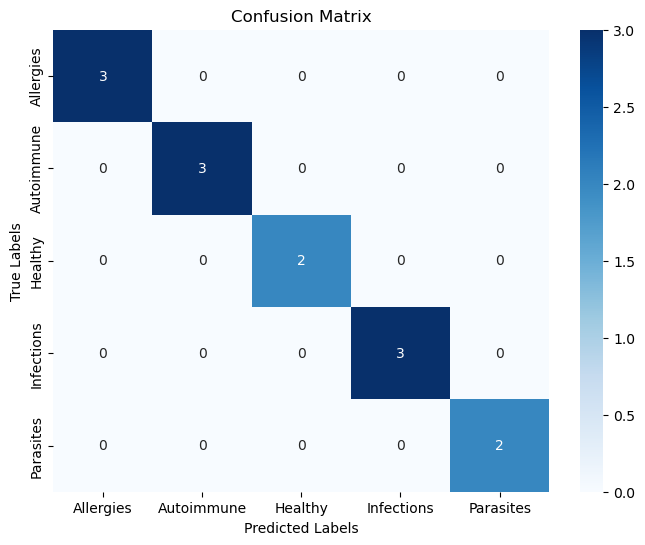

Classification Report:
              precision    recall  f1-score   support

   Allergies       1.00      1.00      1.00         3
  Autoimmune       1.00      1.00      1.00         3
     Healthy       1.00      1.00      1.00         2
  Infections       1.00      1.00      1.00         3
   Parasites       1.00      1.00      1.00         2

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una matriz para almacenar el mejor modelo y su fold
best_model = None
best_accuracy = 0
best_fold = None

for train_index, test_index in kf.split(images, np.argmax(labels, axis=1)):
    print(f"Training Fold {fold}...")
    x_train, x_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Entrenar el modelo
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=20,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluar el modelo en el fold actual
    eval_result = model.evaluate(x_test, y_test, verbose=0)
    accuracies.append(eval_result[1])
    print(f"Fold {fold} Accuracy: {eval_result[1]}")
    
    # Guardar el mejor modelo
    if eval_result[1] > best_accuracy:
        best_accuracy = eval_result[1]
        best_fold = fold
        best_model = model  # Guardar el mejor modelo
    
    fold += 1

print(f"Cross-Validation Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")
print(f"Best Fold: {best_fold} with Accuracy: {best_accuracy}")

# Matriz de confusión con el mejor modelo
print("Generating Confusion Matrix for the Best Model...")
y_pred = best_model.predict(x_test)  # Predicciones en el conjunto de prueba
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a etiquetas
y_true = np.argmax(y_test, axis=1)  # Convertir etiquetas categóricas a índices

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

# Reporte de clasificación
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=train_generator.class_indices.keys()))
